# How to use Florence-2

This notebook shows how to use **Florence-2**, the foundational vision model from Microsoft, and is associated with the article **[Florence-2: How it works and how to use it](https://www.assemblyai.com/blog/florence-2-how-it-works-how-to-use)**.

**It is recommended to run this notebook in Colab - if you are coming from the associated repository, you can find the link to the colab [here](https://colab.research.google.com/drive/1gD56EBmQ7MZfBkyhGtcrvHtaD2KMSm6W?usp=sharing)**.

If you run this locally you will also need to install the packages in the requirements file.



## Setup

First, we need to install packages beyond those pre-installed in Colab in order to run Florence-2.

In [ ]:
%%capture
!pip install timm flash_attn einops;

Next, we clone the associated repository and move the files into the working directory.

In [ ]:
%%bash
git clone https://github.com/oconnoob/redact-pii-python
mv redact-pii-python/** .
rm -rf ./redact-pii-python/

Cloning into 'redact-pii-python'...


Now we import the packages we'll need, including the `utils.py` module from the repository that we just cloned. This file provides misellaneous functionality to make it easier to work with Florence-2.

In [ ]:
import copy

from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests

import utils

%matplotlib inline

Next we load the Florence-2 model and processor

In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

And then we set these models as constants for our `utils.py` module so that the functions can utilize them as global constants.

In [ ]:
utils.set_model_info(model, processor)

Finally, we'll specify the image that we will use for processing. We keep the raw image file for visuals and also convert the image to RGB for passing into Florence-2.

In [ ]:
path = "./car.png"
image = Image.open(path)
image_rgb = Image.open(path).convert("RGB")

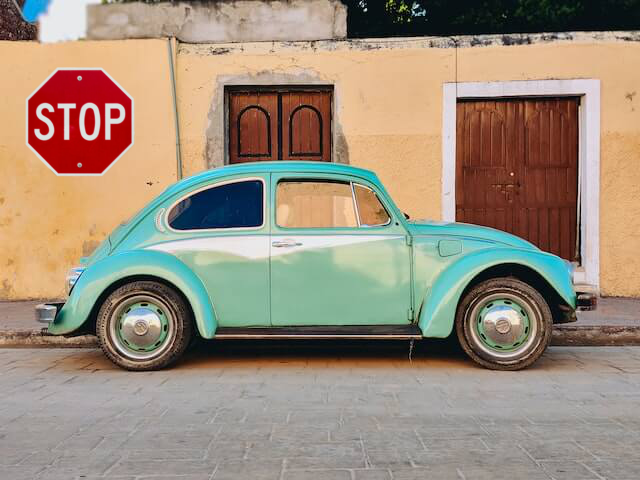

In [ ]:
image

## Florence-2 tasks

Florence-2 is capable of a wide variety of tasks, which are specified to the model as special tokens. Below we overview the tasks that Florence-2 can complete.

Note that the term "Natural language" is an umbrella term that includes descriptive language, "categorical" language, and the visual representation of language. Additionally, "region" refers to a general section of an image (bounding quadrilateral), whereas "segment" refers to a particular section of an image as denoted by a border curve.

The tasks are categorized by additional input needed beyond the image being analyzed - either no additional input, an additional bounding box for a region, or an additional textual input.
<br><br>

## No additional input

| Task category         | Output                       | Description                                                                                                             | Associated Task Tokens                         |
|-----------------------|------------------------------|-------------------------------------------------------------------------------------------------------------------------|------------------------------------------------|
| Captioning            | Natural Language             | Generates a natural language descriptive caption for an entire image                                                    | CAPTION<br>DETAILED_CAPTION<br>MORE_DETAILED_CAPTION |
| Character Recognition | Natural Language<br>(+ Regions) | Detects and returns text that is contained in an image, potentially also returning bounding boxes for the detected text | OCR<br>OCR_WITH_REGION                            |
| Object Detection      | Regions<br>(+ Natural Language) | Proposes bounding boxes for salient objects, optionally with either categorical or descriptive labels              | REGION_PROPOSAL<br>OD<br>DENSE_REGION_CAPTION                                |

## Region Input

| Task category    | Output                       | Description                                                                                                | Associated Task Tokens                   |
|------------------|------------------------------|------------------------------------------------------------------------------------------------------------|------------------------------------------|
| Segmentation     | Segments                     | Detects segments for provided regions (i.e. border detection)                                              | REGION_TO_SEGMENTATION                   |
| Description      | Natural Language             | Provides either a categorical or descriptive annotation for the contents of a region                   | REGION_TO_CATEGORY<br>REGION_TO_DESCRIPTION |

## Language input

| Task category           | Output   | Description                                                                                                               | Associated Task Tokens            |
|-------------------------|----------|---------------------------------------------------------------------------------------------------------------------------|-----------------------------------|
| Phrase Grounding        | Regions  | Detects regions for salient phrases in a description of an image (one-to-many)                                            | PHRASE_GROUNDING                  |
| Vocabulary Detection    | Regions  | Detects regions for specific objects (mix of phrase grounding and region-proposal), can also detect text                  | OPEN_VOCABULARY_DETECTION         |
| Vocabulary Segmentation | Segments | Detects segments for objects referred to by a particular expression (effectively segment version of vocabulary detection) | REFERRING_EXPRESSION_SEGMENTATION |

<br><br>
Below we'll see how to run Florence-2 for all of these tasks in the order they appear in this list.

### No additional input

The tasks in this section require no additional input beyond the image

#### Captioning

Captioning generates a descriptive natural language annotation for the image as a whole. Florence-2 accommodates 3 levels of linguistic granularity for captioning.

In [ ]:
tasks = [utils.TaskType.CAPTION,
         utils.TaskType.DETAILED_CAPTION,
         utils.TaskType.MORE_DETAILED_CAPTION,]

for task in tasks:
  results = utils.run_example(task, image_rgb)
  print(f'{task.value}{results[task]}')

<CAPTION>
A green car parked in front of a stop sign.

<DETAILED_CAPTION>
The image shows a blue Volkswagen Beetle parked in front of a yellow building with two brown doors and a red stop sign. The sky is a mix of blue and white, and there are a few green trees in the background.

<MORE_DETAILED_CAPTION>
The image shows a vintage car parked on the side of a street. The car is a light blue Volkswagen Beetle with a white stripe running along the side. It is parked in front of a yellow building with two wooden doors. Above the car, there is a red stop sign with the word "STOP" written in white letters. The sky is blue and there are trees in the background.



#### Character recognition

Character recognition (OCR) tasks detect the text present in images, and optionally return bounding boxes for the identified text.

See also [vocab detection](#scrollTo=ouid-bVL53hd&line=1&uniqifier=1) to actively search for the presence of a specific word or phrase.

In [ ]:
task = utils.TaskType.OCR
results = utils.run_example(task, image_rgb)
print('Detected Text: ', results[task])

Detected Text:  
STOP



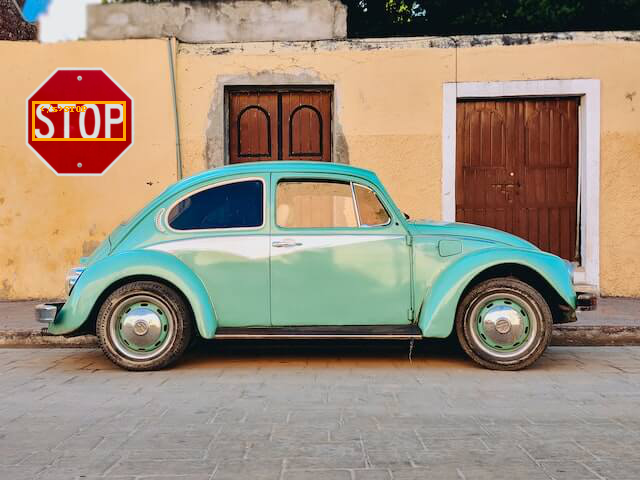

In [ ]:
task = utils.TaskType.OCR_WITH_REGION
results = utils.run_example(task, image_rgb)

# Boxes drawn directly to image, so copy to avoid adulterating image for later tasks
image_copy = copy.deepcopy(image)
utils.draw_ocr_bboxes(image_copy, results[task])

#### Object detection

Object detection automatically detects the salient objects in an image. Florence-2 supports 3 levels of semantic granularity:
1. None (bounding boxes only)
2. Categorical labels
3. Descriptive labels

<REGION_PROPOSAL>


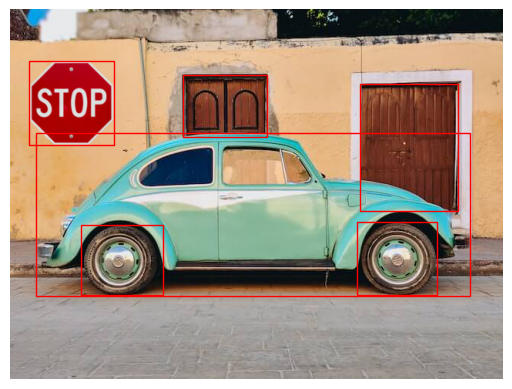

<OD>


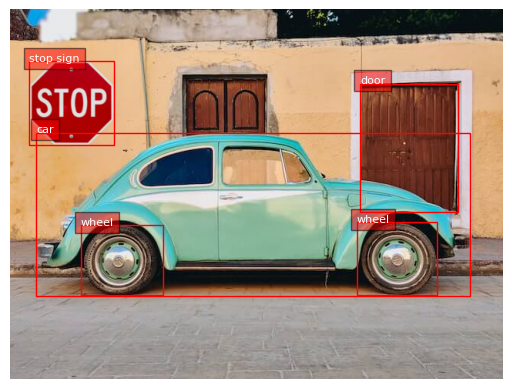

<DENSE_REGION_CAPTION>


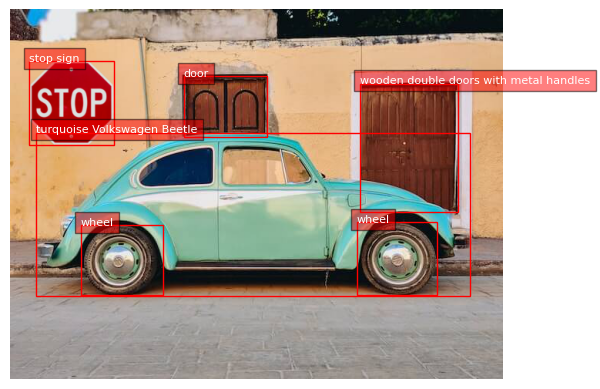

In [ ]:
tasks = [utils.TaskType.REGION_PROPOSAL,
         utils.TaskType.OBJECT_DETECTION,
         utils.TaskType.DENSE_REGION_CAPTION,]

for task in tasks:
  results = utils.run_example(task, image_rgb)
  print(task.value)
  utils.plot_bbox(results[task], image)

### Region input

The tasks in this section require an additional bounding box input in addition to the image

#### Segmentation

Segmentation converts a specified region into a segment (i.e. bounding border)

In [ ]:
top_left=[702, 575]
bottom_right=[866, 772]

task_prompt = utils.TaskType.REG_TO_SEG
# converts coordinates to format `"<loc_x1><loc_y1><loc_x2><loc_y2>"`
text_input = utils.convert_relative_to_loc(top_left + bottom_right)

results = utils.run_example(task_prompt, image_rgb, text_input=text_input)

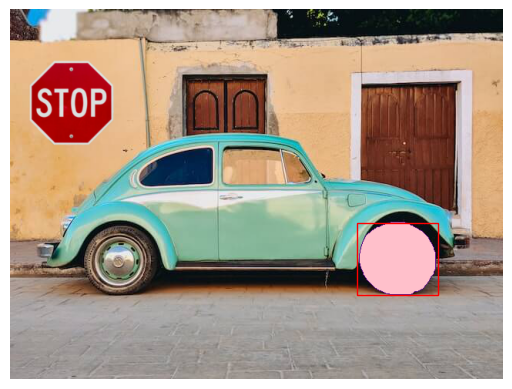

In [ ]:
bbox_coords = utils.convert_relative_to_bbox(top_left + bottom_right, image)
box = {'bboxes': [bbox_coords], 'labels': ['']}

# draw input bounding box and output segment
image_copy = copy.deepcopy(image)
image_copy = utils.draw_polygons(image_copy, results[task_prompt], fill_mask=True)
utils.plot_bbox(box, image_copy)

#### Region description

Region description rescribes a region with either a categorical or descriptive annotation

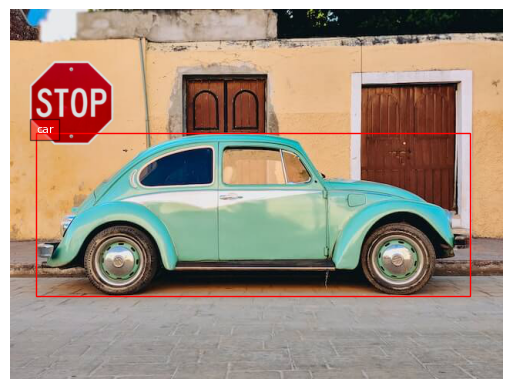

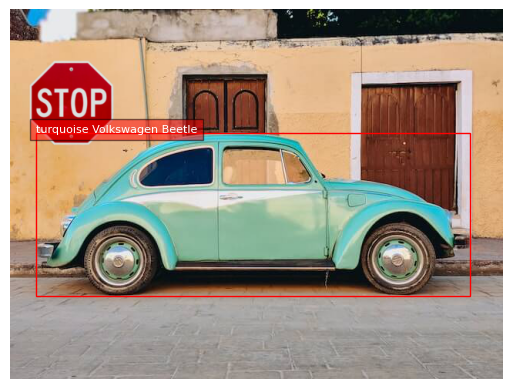

In [ ]:
top_left = [52, 332]
bottom_right = [932, 774]
text_input = utils.convert_relative_to_loc(top_left + bottom_right)
bbox = utils.convert_relative_to_bbox(top_left + bottom_right, image)

for task_prompt in [utils.TaskType.REGION_TO_CATEGORY, utils.TaskType.REGION_TO_DESCRIPTION]:
  results = utils.run_example(task_prompt, image_rgb, text_input=text_input)
  text_result = results[task_prompt].strip().split('<')[0]

  box = {'bboxes': [bbox], 'labels': [text_result]}
  utils.plot_bbox(box, image)

### Language input


The tasks in this section require an additional linguistic input in addition to the image

#### Phrase grounding

Given a descriptive annotation of the image (usually the image in its entirety, i.e. a caption), phrase grounding identifies salient phrases in the annotation and prescribes a bounding box to each one

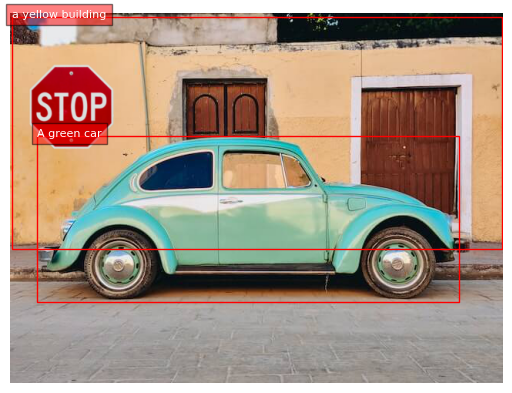

In [ ]:
task_prompt = utils.TaskType.PHRASE_GROUNDING
results = utils.run_example(task_prompt, image_rgb, text_input="A green car parked in front of a yellow building.")
utils.plot_bbox(results[utils.TaskType.PHRASE_GROUNDING], image)

#### Vocab detection

Vocabulary detection is like the inverse of [region description](#scrollTo=9a1ffcf4-4404-4b6d-aee8-6c055da51301&line=3&uniqifier=1) - rather than supplying a region and getting a description, you supply a description and receive the associated region.

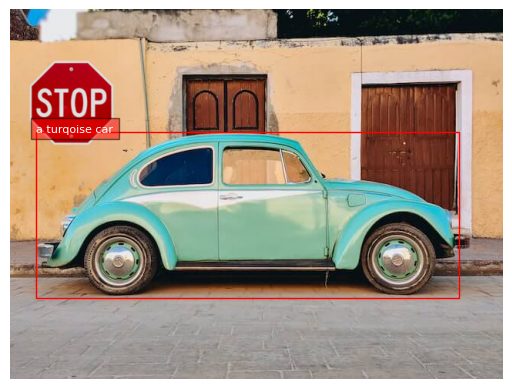

In [ ]:
task_prompt = utils.TaskType.OPEN_VOCAB_DETECTION
results = utils.run_example(task_prompt, image_rgb, text_input="a turqoise car")
bbox_results  = utils.convert_to_od_format(results[utils.TaskType.OPEN_VOCAB_DETECTION])
utils.plot_bbox(bbox_results, image)

Vocabulary detection also works with visual language (i.e. text that is in the image)

See also [character recognition](#scrollTo=1dee1c41-0e99-41e8-b647-373cf84aa6a7&line=5&uniqifier=1) to detect all text without searching for a specified word/phrase.

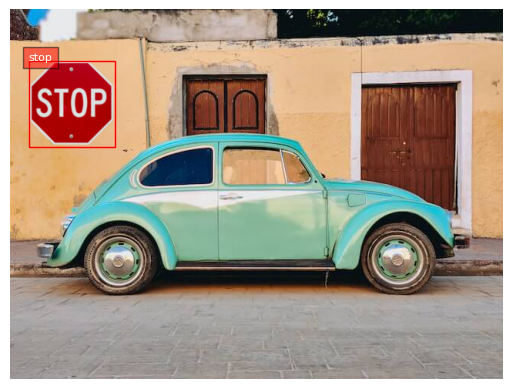

In [ ]:
task_prompt = utils.TaskType.OPEN_VOCAB_DETECTION
results = utils.run_example(task_prompt, image_rgb, text_input="stop")
bbox_results  = utils.convert_to_od_format(results[utils.TaskType.OPEN_VOCAB_DETECTION])
utils.plot_bbox(bbox_results, image)

#### Vocab segmentation

Vocbulary segmentation is like vocabulary detection, except it returns segments rather than regions and cannot identify visual text.

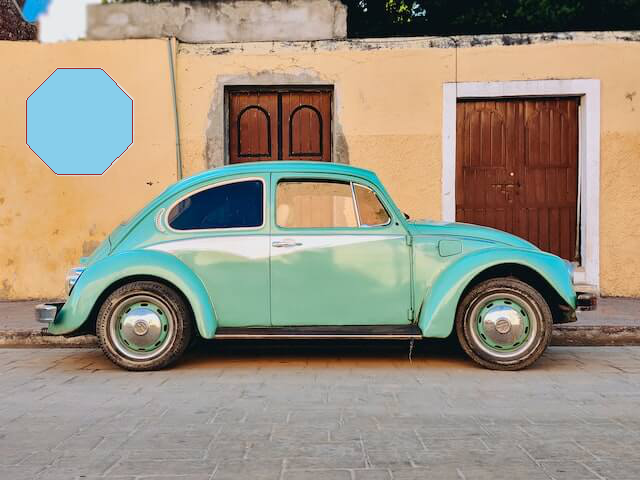

In [ ]:
task_prompt = utils.TaskType.RES
results = utils.run_example(task_prompt, image_rgb, text_input="a stop sign")
image_copy = copy.deepcopy(image)
utils.draw_polygons(image_copy, results[utils.TaskType.RES], fill_mask=True)

## Cascaded tasks

### Detailed Caption + Phrase Grounding + Segmentations

Note that we can cascade tasks together - for example given only an image we can use captioning to generate a description of the entire image and then phrase grounding to associate different objects in the image with the caption.

In [ ]:
# Get a caption
task_prompt = utils.TaskType.CAPTION
results = utils.run_example(task_prompt, image_rgb)

# Use the output as the input into the next task (phrase grounding)
text_input = results[task_prompt]
task_prompt = utils.TaskType.PHRASE_GROUNDING
results = utils.run_example(task_prompt, image_rgb, text_input)

results[utils.TaskType.DETAILED_CAPTION] = text_input


A green car parked in front of a stop sign.



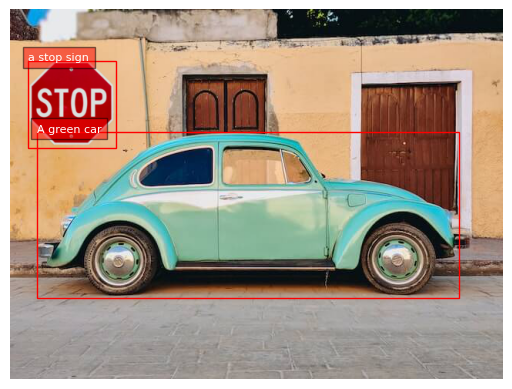

In [ ]:
print(text_input)
utils.plot_bbox(results[utils.TaskType.PHRASE_GROUNDING], image)

We can go a step further and perform region segmentation on the regions identified by the phrase grounding task (whose input was, in turn, supplied by the output of the caption task)

In [ ]:
polygons = []
task_prompt = utils.TaskType.REG_TO_SEG

# Run region to segmentation for each region identified by phrase grounding
for box in results[utils.TaskType.PHRASE_GROUNDING.value]['bboxes']:
  box = utils.convert_bbox_to_relative(box, image)
  text_input = utils.convert_relative_to_loc(box)

  run_results = utils.run_example(task_prompt, image_rgb, text_input=text_input)
  polygons += run_results[task_prompt]['polygons']

In [ ]:
# Construct labels list required and created the necessary input dict
labels = []
for polygon in polygons:
  l = []
  for idx, polygon_ in enumerate(polygon):
    l.append('')
  labels.append(l)

seg_results = dict(polygons=polygons, labels=labels)

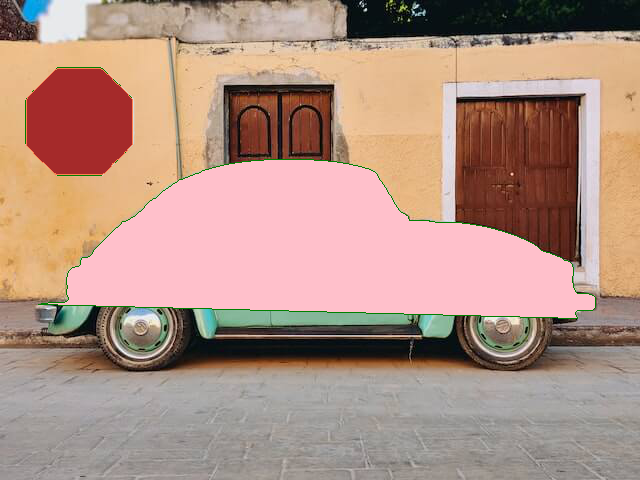

In [ ]:
# draw the output
image_copy = copy.deepcopy(image)
utils.draw_polygons(image_copy, seg_results, fill_mask=True)

# That's it!

Once you're finished with this Colab, head back to the [Final words](https://www.assemblyai.com/blog/florence-2-how-it-works-how-to-use#final-words) of the associated article, or check out our YouTube channel for additional learning resources:

https://www.youtube.com/c/AssemblyAI